In [12]:
import wandb
import yaml
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
from src.tools import check_file_path

url="vincekillerz/traversability-estimation-v4/saved_model:v6"
name="asymformer"+"-"+url.split(":")[-1]
run = wandb.init() 
            
artifact = run.use_artifact(url, type='model')
artifact_dir = artifact.download()
config = yaml.safe_load(open(check_file_path(artifact_dir, 'config.yaml')))
model_path = check_file_path(artifact_dir, 'trained_model.pth')
# Some standard imports


wandb: Downloading large artifact saved_model:v6, 126.27MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:0.4


In [13]:
from src.models.model_builder import model_builder


device = config['ml_orchestrator']['device']
model = model_builder(config['model_builder'])
model.to(device)

# load model
print(model_path)
model.load_state_dict(torch.load(model_path))
model.eval()

/home/gharib-ml/Desktop/master_thesis_v2/artifacts/saved_model:v6/trained_model.pth


B0_T(
  (down_sample_1): down_sample_block(
    (depth_stem): OverlapPatchEmbed(
      (proj): Conv2d(1, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (rgb_stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (rgb_layer): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
      

In [14]:
import torch
import torch.backends.cudnn as cudnn
import time
cudnn.benchmark = True

def benchmark(model, input_shape=(1024, 3, 512, 512), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print('Average throughput: %.2f images/second'%(input_shape[0]/np.mean(timings)))


In [18]:
image = torch.randn(1, 3, 480, 640).to(device)
depth = torch.randn(1, 1, 480, 640).to(device)
torch_out = model(image,depth)
model_path_output ="./models/"+name+'.onnx'
# Export the model
torch.onnx.export(model,               # model being run
                  (image,depth),                         # model input (or a tuple for multiple inputs)
                  model_path_output,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=15,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input_rgb','input_depth'],   # the model's input names
                  output_names = ['output'],# the model's output names
                #   dynamic_axes={'input_rgb' : {0 : 'batch_size'},    # variable length axes
                #                 'input_depth' : {0 : 'batch_size'},
                #                 'output' : {0 : 'batch_size'}})
)

In [5]:
import onnx

onnx_model = onnx.load(model_path_output)
onnx.checker.check_model(onnx_model)

In [6]:
import onnxruntime

ort_session = onnxruntime.InferenceSession(model_path_output, providers=[("CUDAExecutionProvider")])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {
    ort_session.get_inputs()[0].name: to_numpy(image),
    ort_session.get_inputs()[1].name: to_numpy(depth)
    
}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-02, atol=1e-02)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

2024-06-20 16:46:13.110642339 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-06-20 16:46:13.110672189 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


Exported model has been tested with ONNXRuntime, and the result looks good!


cuda


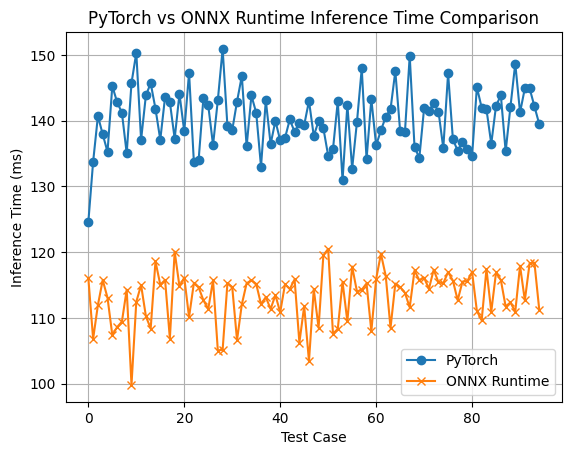

ONNX mean inference time: 113.24 ms
PyTorch mean inference time: 140.16 ms
ONNX is 1.24x faster than PyTorch!


In [7]:
import time
import matplotlib.pyplot as plt
# Lists to store execution times
pytorch_times = []
onnx_times = []
print(device)

batch_size = 4
x = torch.randn(batch_size, 3, 480, 640).to(device)
y = torch.randn(batch_size, 1, 480, 640).to(device)

model = model.to(device)
start_time = time.time()
for i in range(100):  # Conducting 10 tests
    # Generate random inputs

    # Measure PyTorch inference time
    # torch.cuda.synchronize()
    start_time = time.time()
    with torch.no_grad():
        _ = model(x, y)  # Replace '_' with your model's actual output variable if you want to use it
    torch.cuda.synchronize()
    end_time = time.time()
    pytorch_times.append((end_time - start_time) * 1000)  # Convert to milliseconds

    # # Prepare inputs for ONNX Runtime
    # ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x), 
    #               ort_session.get_inputs()[1].name: to_numpy(y)}

    io_binding = ort_session.io_binding()
    io_binding.bind_input(
        name="input_rgb",
        device_type="cuda",
        device_id=0,
        element_type=np.float32,
        shape=tuple(x.shape),
        buffer_ptr=x.data_ptr(),
    )
    io_binding.bind_input(
        name="input_depth",
        device_type="cuda",
        device_id=0,
        element_type=np.float32,
        shape=tuple(y.shape),
        buffer_ptr=y.data_ptr(),
    )
    logit_output_shape = (4,1,480, 640)
    logit_output = torch.empty(logit_output_shape, dtype=torch.float32, device='cuda').contiguous()
    io_binding.bind_output(
        name="output",
        device_type="cuda",
        device_id=0,
        element_type=np.float32,
        shape=tuple(logit_output.shape),
        buffer_ptr=logit_output.data_ptr()
    )
    # Measure ONNX Runtime inference time
    torch.cuda.synchronize()
    start_time = time.time()
    _ = ort_session.run_with_iobinding(io_binding)  # Replace '_' with your ONNX model's actual output variable if you want to use it
    torch.cuda.synchronize()
    end_time = time.time()

    onnx_times.append((end_time - start_time) * 1000)  # Convert to milliseconds

pytorch_times = pytorch_times[5:]
onnx_times = onnx_times[5:]
# Plot comparison of execution times
plt.plot(pytorch_times, label='PyTorch', marker='o')
plt.plot(onnx_times, label='ONNX Runtime', marker='x')
plt.legend()
plt.xlabel('Test Case')
plt.ylabel('Inference Time (ms)')
plt.title('PyTorch vs ONNX Runtime Inference Time Comparison')
plt.grid(True)
plt.show()
# compare mean
pytorch_mean = np.mean(pytorch_times)
onnx_mean = np.mean(onnx_times)
print(f"ONNX mean inference time: {onnx_mean:.2f} ms")
print(f"PyTorch mean inference time: {pytorch_mean:.2f} ms")
print(f"ONNX is {pytorch_mean/onnx_mean:.2f}x faster than PyTorch!")

In [8]:
import onnx
import numpy as np

def is_overflow_in_fp16(tensor):
    original_data = np.asarray(tensor, dtype=np.float32)
    fp16_data = original_data.astype(np.float16)
    back_converted_data = fp16_data.astype(np.float32)

    diff = np.abs(back_converted_data - original_data)
    return np.any(diff > 0.001)

def is_truncated_in_fp16(tensor):
    original_data = np.asarray(tensor, dtype=np.float32)

    return np.any(np.abs(original_data) <= 0.0000001)  # Check if the FP16 weight is zero



model = onnx.load(model_path_output)  # Load ONNX model
overflow_list=[]
for node in model.graph.node:
    if node.input:  # Check network layer which has 'input'
        for input_name in node.input:
            weight = next((init for init in model.graph.initializer if init.name == input_name), None)
            if weight is not None:  # Make sure the layer has 'weight'
                weights = onnx.numpy_helper.to_array(weight)
                if is_overflow_in_fp16(weights):
                    print(f"Node {node.name} ({node.op_type}): Weight overflow in fp16")
                    overflow_list.append(node.name)
                if is_truncated_in_fp16(weights):
                    print(f"Node {node.name} ({node.op_type}): Weight truncated in fp16")
                    overflow_list.append(node.name)

print('个数：',len(overflow_list))

Node /down_sample_1/rgb_layer/rgb_layer.2/dwconv/Conv (Conv): Weight truncated in fp16
Node /down_sample_1/depth_layer.0/attn/kv/Add (Add): Weight truncated in fp16
Node /down_sample_2/rgb_stem/rgb_stem.1/Conv (Conv): Weight overflow in fp16
Node /down_sample_2/rgb_layer/rgb_layer.0/pwconv1/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_2/rgb_layer/rgb_layer.0/pwconv2/Add (Add): Weight overflow in fp16
Node /down_sample_2/rgb_layer/rgb_layer.2/Mul (Mul): Weight overflow in fp16
Node /down_sample_2/depth_layer.1/attn/kv/Add (Add): Weight truncated in fp16
Node /down_sample_2/SCC/cross_atten/bn_x1/BatchNormalization (BatchNormalization): Weight overflow in fp16
Node /down_sample_2/SCC/cross_atten/bn_x2/BatchNormalization (BatchNormalization): Weight overflow in fp16
Node /down_sample_2/SCC/cross_atten/bn_x2/BatchNormalization (BatchNormalization): Weight overflow in fp16
Node /down_sample_3/rgb_stem/rgb_stem.1/Conv (Conv): Weight truncated in fp16
Node /down_sample_3/rgb_ste

/tmp/ipykernel_3108576/3818076605.py:6: RuntimeWarning: overflow encountered in cast
  fp16_data = original_data.astype(np.float16)


Node /down_sample_4/rgb_layer/rgb_layer.1/pwconv1/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/rgb_layer/rgb_layer.1/pwconv2/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/rgb_layer/rgb_layer.1/pwconv2/Add (Add): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.1/Mul (Mul): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/dwconv/Conv (Conv): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/norm/LayerNormalization (LayerNormalization): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/norm/LayerNormalization (LayerNormalization): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/pwconv1/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/pwconv2/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/Mul (Mul): Weight overflow in fp16
Node /down_sample_4/depth_layer.0/attn/kv/Add (Add): Weight truncated in fp16
Node 

In [21]:
import os
import tensorrt as trt

def build_engine(onnx_file_path, engine_file_path, overflow_list, flop=16):
    trt_logger = trt.Logger(trt.Logger.WARNING)  # trt.Logger.ERROR
    builder = trt.Builder(trt_logger)
    builder_config = builder.create_builder_config()
    
    network = builder.create_network(
        1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    )
    
    parser = trt.OnnxParser(network, trt_logger)
    # parse ONNX
    with open(onnx_file_path, 'rb') as model:
        if not parser.parse(model.read()):
            print('ERROR: Failed to parse the ONNX file.')
            for error in range(parser.num_errors):
                print(parser.get_error(error))
            return None
    print("Completed parsing ONNX file")

    # default = 1 for fixed batch size
    builder.max_batch_size = 1
    # set mixed flop computation for the best performance

    builder_config.set_flag(trt.BuilderFlag.FP16)

    if os.path.isfile(engine_file_path):
        try:
            os.remove(engine_file_path)
        except Exception:
            print("Cannot remove existing file: ",
                engine_file_path)

    print("Creating Tensorrt Engine")

    for layer in network:
        for layer_name in overflow_list:
            if layer_name in layer.name:
                layer.precision = trt.float32
                print(f'Network Layer: {layer.name}, {layer.type}, {layer.precision}, is_set: {layer.precision_is_set}')

    config = builder.create_builder_config()
    config.set_tactic_sources(1 << int(trt.TacticSource.CUBLAS))
    config.max_workspace_size = 2 << 30
    config.set_flag(trt.BuilderFlag.FP16)
    config.set_flag(trt.BuilderFlag.STRICT_TYPES)

    print('config.flags: ', config.flags)
    profile = builder.create_optimization_profile()



    profile.set_shape("input_rgb", (1, 3, 480, 640), (1, 3, 480, 640),(1, 3, 480, 640))   
    profile.set_shape("input_depth", (1, 1, 480, 640), (1, 1, 480, 640),(1, 1, 480, 640))   
    profile.set_shape("output", (1, 1, 480, 640), (1, 1, 480, 640),(30, 1, 480, 640)) 


    config.add_optimization_profile(profile)
    engine = builder.build_engine(network, config)
    with open(engine_file_path, "wb") as f:
        f.write(engine.serialize())
    print("Serialized Engine Saved at: ", engine_file_path)
    return engine

In [22]:
ONNX_SIM_MODEL_PATH = model_path_output

TENSORRT_ENGINE_PATH_PY = "./models/"+name+'.engine'

build_engine(ONNX_SIM_MODEL_PATH, TENSORRT_ENGINE_PATH_PY, overflow_list)

[06/20/2024-18:38:15] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
Completed parsing ONNX file
Creating Tensorrt Engine
Network Layer: /down_sample_1/rgb_layer/rgb_layer.2/dwconv/Conv, LayerType.CONVOLUTION, DataType.FLOAT, is_set: True
Network Layer: /down_sample_1/depth_layer.0/attn/kv/Add, LayerType.ELEMENTWISE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/rgb_stem/rgb_stem.1/Conv, LayerType.CONVOLUTION, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/rgb_layer/rgb_layer.0/pwconv1/MatMul, LayerType.MATRIX_MULTIPLY, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/rgb_layer/rgb_layer.0/pwconv2/Add, LayerType.ELEMENTWISE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/rgb_layer/rgb_layer.2/Mul, LayerType.ELEMENTWISE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/depth_layer.1/attn/kv/Add, LayerType.ELE

/tmp/ipykernel_3108576/1555057692.py:24: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  builder.max_batch_size = 1
/tmp/ipykernel_3108576/1555057692.py:46: DeprecationWarning: Use set_memory_pool_limit instead.
  config.max_workspace_size = 2 << 30



Network Layer: /down_sample_4/depth_layer.1/attn/proj/MatMul, LayerType.MATRIX_MULTIPLY, DataType.FLOAT, is_set: True
Network Layer: /down_sample_4/depth_layer.1/mlp/fc2/MatMul, LayerType.MATRIX_MULTIPLY, DataType.FLOAT, is_set: True
Network Layer: /down_sample_4/SCC/fus_atten/fc_spatial/fc_spatial.0/MatMul, LayerType.MATRIX_MULTIPLY, DataType.FLOAT, is_set: True
Network Layer: /down_sample_4/SCC/fus_atten/fc_spatial/fc_spatial.2/MatMul, LayerType.MATRIX_MULTIPLY, DataType.FLOAT, is_set: True
Network Layer: /down_sample_4/SCC/conv1/Conv, LayerType.CONVOLUTION, DataType.FLOAT, is_set: True
Network Layer: /down_sample_4/SCC/cross_atten/bn_x1/BatchNormalization, LayerType.SCALE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_4/SCC/cross_atten/bn_x2/BatchNormalization, LayerType.SCALE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_4/SCC/cross_atten/bn_x2/BatchNormalization, LayerType.SCALE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_4/SCC/cross_atten/kq2

/tmp/ipykernel_3108576/1555057692.py:61: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


[06/20/2024-18:38:16] [TRT] [W] Detected layernorm nodes in FP16: /down_sample_2/rgb_layer/rgb_layer.0/norm/ReduceMean_1, /down_sample_4/depth_stem/norm/Sub, /down_sample_4/depth_stem/norm/Pow, /down_sample_4/depth_stem/norm/ReduceMean_1, /down_sample_4/depth_stem/norm/Add, /down_sample_1/depth_layer.0/attn/norm/Sub, /down_sample_1/depth_layer.0/attn/norm/Pow, /down_sample_1/depth_layer.0/attn/norm/Add, /down_sample_1/depth_layer.0/attn/norm/Sqrt, /down_sample_1/depth_layer.0/attn/norm/Div, /down_sample_1/rgb_layer/rgb_layer.1/norm/Sub, /down_sample_1/depth_layer.0/attn/norm/Mul, /down_sample_1/rgb_layer/rgb_layer.1/norm/Pow, /down_sample_1/depth_layer.0/attn/norm/Add_1, /down_sample_1/rgb_layer/rgb_layer.1/norm/Add, /down_sample_1/rgb_layer/rgb_layer.1/norm/Sqrt, /down_sample_1/rgb_layer/rgb_layer.1/norm/Div, /down_sample_1/rgb_layer/rgb_layer.1/norm/Mul, /down_sample_1/rgb_layer/rgb_layer.1/norm/Add_1, /down_sample_1/depth_layer.0/norm2/Sub, /down_sample_1/depth_layer.0/norm2/Pow, /d

In [23]:
print(trt.__version__)

8.5.3.1
